## Finding Your Way In The City

In this notebook you'll combine the work of previous exercises to calculate a minimal series of waypoints in order to get from a start location to a goal location.

You'll reuse and modify your algorithms from:

- A*
- Configuration Space
- Collinearity and/or Bresenham

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from queue import PriorityQueue
from enum import Enum
%matplotlib inline

#from bresenham import bresenham

In [2]:
plt.rcParams['figure.figsize'] = 15, 15

You'll notice we've imported `create_grid`, and `a_star`. These are functions you've implemented in previous exercises, and here you'll use them to create a map and find a path from a starting position to a goal position.

To read the function signature and documentation execute `?` followed by the function name in a cell. In the example below we'll check the documentation for `create_grid`.

In [4]:
?create_grid

Object `create_grid` not found.


If you would like to alter these implementations, you can modify [grid.py](/edit/grid.py) and [planning.py](/edit/planning.py) in the current directory.

In [31]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [49]:
# Static drone altitude (meters)
drone_altitude = 5

# Minimum distance stay away from obstacle (meters)
safe_distance = 3

In [57]:
def create_grid(data,drone_altitude,safe_distance):
    #first need to find the north and east minias and maximas
    north_min = np.floor(np.min( data[:,0] - data[:,3]))
    north_max = np.ceil( np.max(data[:,0] +data[:,3] ))
    east_min =np.floor(np.min(data[:,1] - data[:,4] ))
    east_max = np.ceil(np.max(data[:,1] + data[:,4]))
    
    north_size = int(np.ceil(north_max - north_min) )
    east_size = int(np.ceil(east_max - east_min))

    #define the grid
    grid = np.zeros((north_size , east_size))
    #create the grid
    for index in range(len(data)):
        north , east ,alt , d_north , d_east , d_alt = data[index , :]
        #define the obstacle boundries
        obs_north_min = np.floor(north - d_north - safe_distance)
        obs_north_max = np.ceil(north + d_north +safe_distance)
        obs_east_min = np.floor(east -d_east - safe_distance)
        obs_east_max = np.ceil(east + d_east + safe_distance)
        obs_alt = alt + d_alt+safe_distance
        if(obs_alt > drone_altitude):
            #fill the grid
            obs_nmin_north  = int(np.floor(obs_north_min - north_min))
            obs_nmax_north = int(np.ceil(obs_north_max - north_min))
            obs_nmin_east = int(np.floor(obs_east_min - east_min))
            obs_nmax_east = int(np.ceil(obs_east_max - east_min))
            for i in range(obs_nmin_north , obs_nmax_north+1):
                for j in range(obs_nmin_east , obs_nmax_east+1):
                    if( (0<=i<=north_size-1) and (0<=j<=east_size-1) ):
                        grid[i,j]=1

    return grid

grid = create_grid(data, drone_altitude, safe_distance)
print(grid)

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


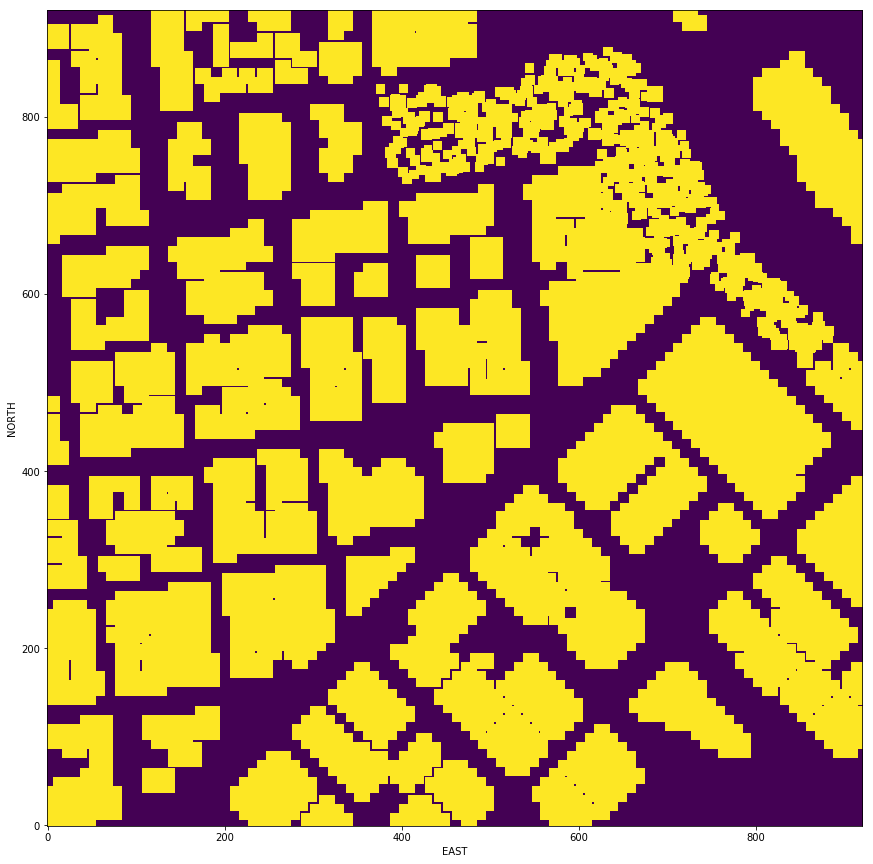

In [58]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
# NOTE: we're placing the origin in the lower lefthand corner here
# so that north is up, if you didn't do this north would be positive down
plt.imshow(grid, origin='lower') 

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Next you'll compute the path from a start location to a goal location using A*.

Start and goal coordinates in *(north, east)*.

In [37]:
#defined coordinate system (north ,east)
start_ne = (25,  100)
goal_ne = (750., 370.)

Write a heuristic function.

In [24]:
#define a cost function for a* algorithm
def heuristic_func(position, goal_position):
    cost = np.linalg.norm([position[0]-goal_position[0], position[1]-goal_position[1]])
    return cost

In [32]:
class Action(Enum):
    """
    An action is represented by a 3 element tuple.
    
    The first 2 values are the delta of the action relative
    to the current grid position. The third and final value
    is the cost of performing the action.
    """
    LEFT = (0, -1, 1)
    RIGHT = (0, 1, 1)
    UP = (-1, 0, 1)
    DOWN = (1, 0, 1)
    
    def __str__(self):
        if self == self.LEFT:
            return '<'
        elif self == self.RIGHT:
            return '>'
        elif self == self.UP:
            return '^'
        elif self == self.DOWN:
            return 'v'
    
    @property
    def cost(self):
        return self.value[2]
    
    @property
    def delta(self):
        return (self.value[0], self.value[1])
            
    
def valid_actions(grid, current_node):
    """
    Returns a list of valid actions given a grid and current node.
    """
    valid = [Action.UP, Action.LEFT, Action.RIGHT, Action.DOWN]
    n, m = grid.shape[0] - 1, grid.shape[1] - 1
    x, y = current_node
    
    # check if the node is off the grid or
    # it's an obstacle
    
    if x - 1 < 0 or grid[x-1, y] == 1:
        valid.remove(Action.UP)
    if x + 1 > n or grid[x+1, y] == 1:
        valid.remove(Action.DOWN)
    if y - 1 < 0 or grid[x, y-1] == 1:
        valid.remove(Action.LEFT)
    if y + 1 > m or grid[x, y+1] == 1:
        valid.remove(Action.RIGHT)
        
    return valid

Compute the lowest cost path with `a_star`. 

In [56]:
def a_start_search(grid , start_ne , goal_ne):
    #define the data structuers
    path=[]
    queue = PriorityQueue()
    visited=set()
    queue.put((0,start_ne))
    visited.add(start_ne)
    branch={}
    Found = False
    while not queue.empty():
        new_val = queue.get()
        current_node = new_val[1]
        current_cost = new_val[0]
        if((current_node[0],current_node[1])==goal_ne):
            print("Found a path")
            Found = True
            break
        for action in valid_actions(grid , current_node):
            action_cost = action.cost
            action_move= action.delta
            new_node = ((current_node[0]+action_move[0] , current_node[1]+action_move[1]))
            branch_cost = current_cost + action_cost
            total_cost = branch_cost + heuristic_func(current_node , goal_ne)
           
            if(new_node not in visited):
                visited.add(new_node)
                queue.put((total_cost ,new_node ))
                branch[new_node]=[branch_cost,current_node]
    path_cost =branch[goal_ne][0]
    n=goal_ne
    if Found:
        while branch[n][1]!=start_ne:
            path.append(branch[n][1])
            n=branch[n][1]
        path.append(branch[n][1])

    return path[::-1], path_cost


path, cost = a_start_search(grid, start_ne,goal_ne)

Found a path


In [58]:
print(path)

[(25, 100), (26, 100), (27, 100), (28, 100), (29, 100), (30, 100), (31, 100), (32, 100), (33, 100), (34, 100), (35, 100), (36, 100), (37, 100), (38, 100), (39, 100), (40, 100), (41, 100), (42, 100), (43, 100), (44, 100), (45, 100), (46, 100), (47, 100), (48, 100), (49, 100), (50, 100), (51, 100), (52, 100), (53, 100), (54, 100), (55, 100), (56, 100), (57, 100), (58, 100), (59, 100), (60, 100), (61, 100), (62, 100), (63, 100), (64, 100), (65, 100), (66, 100), (67, 100), (68, 100), (69, 100), (70, 100), (71, 100), (72, 100), (73, 100), (74, 100), (75, 100), (76, 100), (77, 100), (78, 100), (79, 100), (80, 100), (81, 100), (82, 100), (83, 100), (84, 100), (85, 100), (86, 100), (87, 100), (88, 100), (89, 100), (90, 100), (91, 100), (92, 100), (93, 100), (94, 100), (95, 100), (96, 100), (97, 100), (98, 100), (99, 100), (100, 100), (101, 100), (102, 100), (103, 100), (104, 100), (105, 100), (106, 100), (107, 100), (108, 100), (109, 100), (110, 100), (111, 100), (112, 100), (113, 100), (114, 

Let's plot the path!

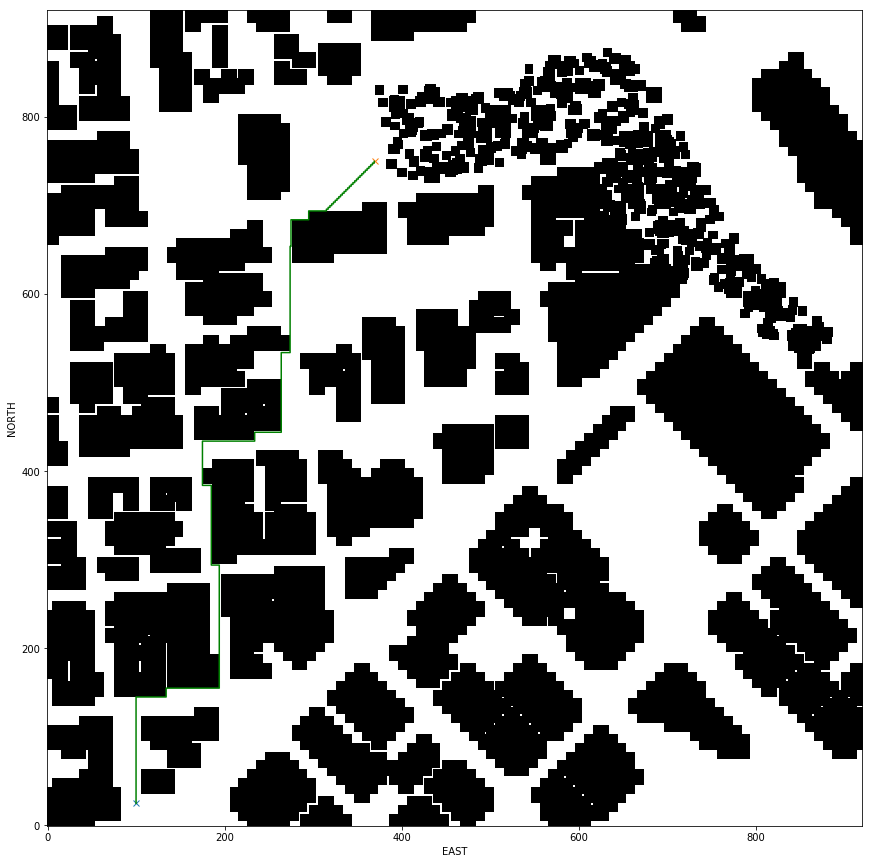

In [57]:
plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

if path is not None:
    pp = np.array(path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Pretty neat! Unfortunately this path is impractical, the drone would be constantly stopping and going since each grid cell visited is synonymous with a waypoint. Ideally, we'd like to only consider a new waypoint when the drone's direction changes. Path pruning is one way to achieve this result.

### Path Pruning

In [99]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

Complete the `prune_path` function below. It should return a new path much shorter than the original.

In [110]:
def prune_path(path):
    if path is not None:
        valid_path=[]
        pruned_path = [p for p in path]
        pruned_check = [ 0 for i in range(len(path))]
        for index in range(len(pruned_path)):
            if(len(pruned_path)-index >= 3):
                p1,p2,p3=pruned_path[index:index+3]
                p1,p2,p3 = point(p1),point(p2),point(p3)
                bool = collinearity_check(p1,p2,p3)
                if(bool ==True):
                    pruned_check[index+1]=1
        for index,val in enumerate(pruned_check):
            if val ==0:
                valid_path.append(pruned_path[index])
    else:
        pruned_path = path
        valid_path=path
        
    return valid_path

Prune the path.

In [111]:
pruned_path = prune_path(path)
print(pruned_path)

[(25, 100), (145, 100), (145, 134), (155, 134), (155, 194), (294, 194), (294, 185), (384, 185), (384, 175), (434, 175), (434, 234), (444, 234), (444, 264), (534, 264), (534, 274), (654, 274), (654, 275), (684, 275), (684, 295), (694, 295), (694, 315), (696, 315), (696, 317), (698, 317), (698, 319), (700, 319), (700, 321), (702, 321), (702, 323), (704, 323), (704, 325), (706, 325), (706, 327), (708, 327), (708, 329), (710, 329), (710, 331), (712, 331), (712, 333), (714, 333), (714, 335), (716, 335), (716, 337), (718, 337), (718, 339), (720, 339), (720, 341), (722, 341), (722, 343), (724, 343), (724, 345), (726, 345), (726, 347), (728, 347), (728, 349), (730, 349), (730, 351), (732, 351), (732, 353), (734, 353), (734, 355), (736, 355), (736, 357), (738, 357), (738, 359), (740, 359), (740, 361), (742, 361), (742, 363), (744, 363), (744, 365), (746, 365), (746, 367), (748, 367), (748, 369), (750, 369)]


In [ ]:
pruned_path

Replot the path, it will be the same as before but the drone flight will be much smoother.

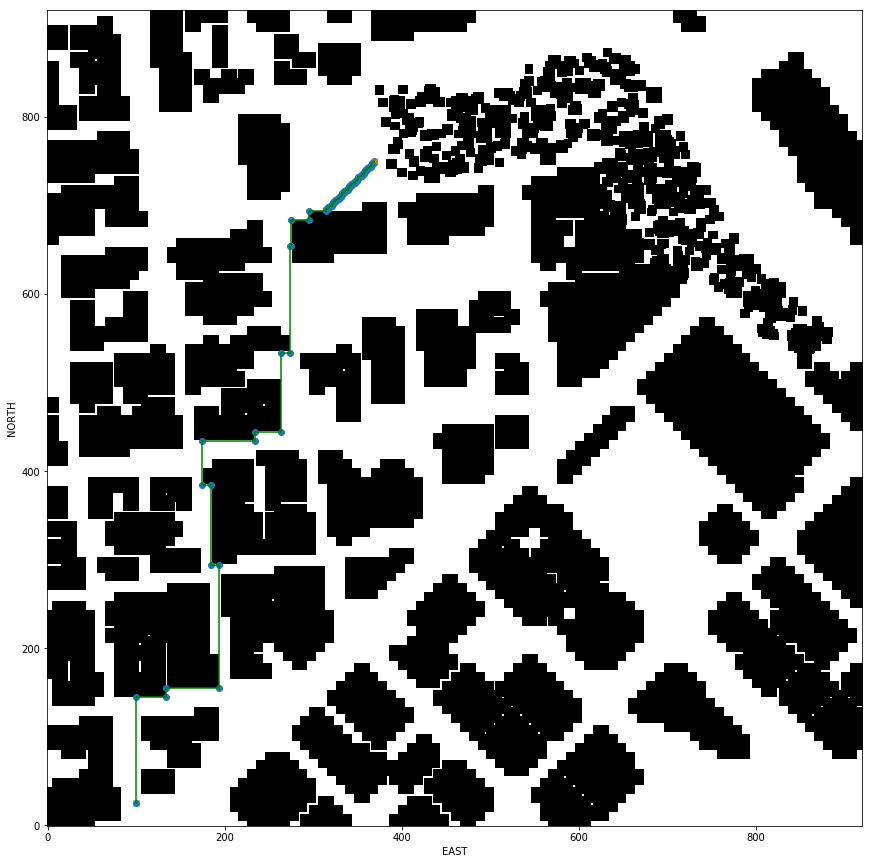

In [112]:
plt.imshow(grid, cmap='Greys', origin='lower')

plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

if pruned_path is not None:
    pp = np.array(pruned_path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')
    plt.scatter(pp[:, 1], pp[:, 0])

plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

Now the waypoints symbolize a change in direction, much better!